In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
torch.cuda.is_available()

True

# train_dataset 

In [3]:
trainset_x = pd.read_csv("train_x.csv")
trainset_y = pd.read_csv("train_theta.csv")

In [4]:
print(trainset_x.shape)
print(trainset_y.shape)

(100000000, 1)
(1000000, 2)


In [5]:
y1_tensor = torch.tensor(trainset_y.theta1,dtype=torch.float32).reshape(-1,1)
y2_tensor = torch.tensor(trainset_y.theta2,dtype=torch.float32).reshape(-1,1)

In [6]:
train_x = torch.tensor(trainset_x.x,dtype=torch.float32).reshape(-1,100)
train_y = torch.hstack((y1_tensor,y2_tensor))

In [7]:
print(train_x.shape)
print(train_y.shape)

torch.Size([1000000, 100])
torch.Size([1000000, 2])


# validation set

In [8]:
validset_x = pd.read_csv("valid_x.csv")
validset_y = pd.read_csv("valid_theta.csv")

In [9]:
print(validset_x.shape)
print(validset_y.shape)

(10000000, 1)
(100000, 2)


In [11]:
y1_tensor = torch.tensor(validset_y.theta1,dtype=torch.float32).reshape(-1,1)
y2_tensor = torch.tensor(validset_y.theta2,dtype=torch.float32).reshape(-1,1)

In [12]:
valid_x = torch.tensor(validset_x.x,dtype=torch.float32).reshape(-1,100)
valid_y = torch.hstack((y1_tensor,y2_tensor))

In [13]:
print(valid_x.shape)
print(valid_y.shape)

torch.Size([100000, 100])
torch.Size([100000, 2])


# test datset 

In [14]:
testset_x = pd.read_csv("test_x.csv")
testset_y = pd.read_csv("test_theta.csv")

In [15]:
print(testset_x.shape)
print(testset_y.shape)

(10000000, 1)
(100000, 2)


In [16]:
y1_tensor = torch.tensor(testset_y.theta1,dtype=torch.float32).reshape(-1,1)
y2_tensor = torch.tensor(testset_y.theta2,dtype=torch.float32).reshape(-1,1)

In [17]:
test_x = torch.tensor(testset_x.x,dtype=torch.float32).reshape(-1,100)
test_y = torch.hstack((y1_tensor,y2_tensor))

In [18]:
print(train_x.shape)
print(train_y.shape)

print(test_x.shape)
print(test_y.shape)

torch.Size([1000000, 100])
torch.Size([1000000, 2])
torch.Size([100000, 100])
torch.Size([100000, 2])


In [19]:
print(train_x.dtype)
print(train_y.dtype)

print(test_x.dtype)
print(test_y.dtype)

torch.float32
torch.float32
torch.float32
torch.float32


# data loader

In [20]:
# Dataset 상속
class CustomDataset(Dataset): 
  def __init__(self,x_data,y_data):
    self.x_data = x_data
    self.y_data = y_data

  # 총 데이터의 개수를 리턴
  def __len__(self): 
    return len(self.x_data)

  # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
  def __getitem__(self, idx): 
    x = self.x_data[idx]
    y = self.y_data[idx]
    return x, y

# 모델 생성

In [21]:
#Define Neural Networks Model.

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(100, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 2)


    def forward(self, x):
        x = x.float()
        h1 = torch.tanh(self.fc1(x))
        h2 = torch.tanh(self.fc2(h1))
        h3 = torch.tanh(self.fc3(h2))
        out = self.fc4(h3)
        return out

print("init model done")

init model done


In [22]:
# Set Hyper parameters and other variables to train the model.

batch_size = 1000

test_batch_size = 1
epochs = 10
log_interval = 500

lr = 0.05
l2_term = 0 

In [23]:
train_set = CustomDataset(train_x,train_y)
valid_set = CustomDataset(valid_x,valid_y)
test_set = CustomDataset(test_x,test_y)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=True)

In [24]:
if(torch.cuda.is_available() ):
    device = "cuda"
else:
    device ="cpu"

In [25]:
def train(log_interval, model, device, train_loader, epoch,l2_term):
    model.train()
    history = []
    optimizer = optim.SGD(model.parameters(), lr=lr,weight_decay=l2_term)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target) 
        history.append(loss)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    train_history = sum(history)/len(history)
            
    # validation loss 여기다 찍어보자. 
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += F.mse_loss(output, target, reduction='sum').item() 

    val_loss /= len(valid_loader.dataset)

    print('\nValid set: Average loss: {:.4f}\n'.format(val_loss))
    return train_history, val_loss

def test(log_interval, model, device, test_loader):
    model.eval()
    test_loss = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.mse_loss(output, target, reduction='sum').item() 

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))
    
    return output

In [32]:
lr = 0.05
l2_term = 0

In [33]:
model = Net().to(device)

train_history = []
val_history = []
for epoch in range(1, 201):
    train_loss, val_loss = train(log_interval, model, device, train_loader, epoch,l2_term)
    train_history.append(train_loss.item())
    val_history.append(val_loss)
    
torch.save(model, './model.pt')

Train Epoch: 1 [0/1000000 (0%)]	Loss: 0.563932
Train Epoch: 1 [500000/1000000 (50%)]	Loss: 0.447798

Valid set: Average loss: 0.8852

Train Epoch: 2 [0/1000000 (0%)]	Loss: 0.418174
Train Epoch: 2 [500000/1000000 (50%)]	Loss: 0.420070

Valid set: Average loss: 0.4666

Train Epoch: 3 [0/1000000 (0%)]	Loss: 0.231545
Train Epoch: 3 [500000/1000000 (50%)]	Loss: 0.147698

Valid set: Average loss: 0.2265

Train Epoch: 4 [0/1000000 (0%)]	Loss: 0.113522
Train Epoch: 4 [500000/1000000 (50%)]	Loss: 0.096764

Valid set: Average loss: 0.1778

Train Epoch: 5 [0/1000000 (0%)]	Loss: 0.083899
Train Epoch: 5 [500000/1000000 (50%)]	Loss: 0.081495

Valid set: Average loss: 0.1532

Train Epoch: 6 [0/1000000 (0%)]	Loss: 0.074141
Train Epoch: 6 [500000/1000000 (50%)]	Loss: 0.073578

Valid set: Average loss: 0.1369

Train Epoch: 7 [0/1000000 (0%)]	Loss: 0.066921
Train Epoch: 7 [500000/1000000 (50%)]	Loss: 0.068225

Valid set: Average loss: 0.1263

Train Epoch: 8 [0/1000000 (0%)]	Loss: 0.066473
Train Epoch: 8 


Valid set: Average loss: 0.0740

Train Epoch: 62 [0/1000000 (0%)]	Loss: 0.035559
Train Epoch: 62 [500000/1000000 (50%)]	Loss: 0.035583

Valid set: Average loss: 0.0753

Train Epoch: 63 [0/1000000 (0%)]	Loss: 0.035484
Train Epoch: 63 [500000/1000000 (50%)]	Loss: 0.034080

Valid set: Average loss: 0.0762

Train Epoch: 64 [0/1000000 (0%)]	Loss: 0.035573
Train Epoch: 64 [500000/1000000 (50%)]	Loss: 0.037210

Valid set: Average loss: 0.0763

Train Epoch: 65 [0/1000000 (0%)]	Loss: 0.034846
Train Epoch: 65 [500000/1000000 (50%)]	Loss: 0.034084

Valid set: Average loss: 0.0714

Train Epoch: 66 [0/1000000 (0%)]	Loss: 0.038588
Train Epoch: 66 [500000/1000000 (50%)]	Loss: 0.033189

Valid set: Average loss: 0.0715

Train Epoch: 67 [0/1000000 (0%)]	Loss: 0.034176
Train Epoch: 67 [500000/1000000 (50%)]	Loss: 0.032672

Valid set: Average loss: 0.0710

Train Epoch: 68 [0/1000000 (0%)]	Loss: 0.035140
Train Epoch: 68 [500000/1000000 (50%)]	Loss: 0.035680

Valid set: Average loss: 0.0718

Train Epoch: 6


Valid set: Average loss: 0.0642

Train Epoch: 122 [0/1000000 (0%)]	Loss: 0.030045
Train Epoch: 122 [500000/1000000 (50%)]	Loss: 0.029879

Valid set: Average loss: 0.0635

Train Epoch: 123 [0/1000000 (0%)]	Loss: 0.032196
Train Epoch: 123 [500000/1000000 (50%)]	Loss: 0.032574

Valid set: Average loss: 0.0645

Train Epoch: 124 [0/1000000 (0%)]	Loss: 0.030270
Train Epoch: 124 [500000/1000000 (50%)]	Loss: 0.028180

Valid set: Average loss: 0.0629

Train Epoch: 125 [0/1000000 (0%)]	Loss: 0.033179
Train Epoch: 125 [500000/1000000 (50%)]	Loss: 0.028934

Valid set: Average loss: 0.0640

Train Epoch: 126 [0/1000000 (0%)]	Loss: 0.030101
Train Epoch: 126 [500000/1000000 (50%)]	Loss: 0.030568

Valid set: Average loss: 0.0629

Train Epoch: 127 [0/1000000 (0%)]	Loss: 0.029438
Train Epoch: 127 [500000/1000000 (50%)]	Loss: 0.029004

Valid set: Average loss: 0.0630

Train Epoch: 128 [0/1000000 (0%)]	Loss: 0.030845
Train Epoch: 128 [500000/1000000 (50%)]	Loss: 0.029649

Valid set: Average loss: 0.0639



Train Epoch: 181 [500000/1000000 (50%)]	Loss: 0.030456

Valid set: Average loss: 0.0576

Train Epoch: 182 [0/1000000 (0%)]	Loss: 0.029247
Train Epoch: 182 [500000/1000000 (50%)]	Loss: 0.026142

Valid set: Average loss: 0.0582

Train Epoch: 183 [0/1000000 (0%)]	Loss: 0.027648
Train Epoch: 183 [500000/1000000 (50%)]	Loss: 0.029818

Valid set: Average loss: 0.0581

Train Epoch: 184 [0/1000000 (0%)]	Loss: 0.028247
Train Epoch: 184 [500000/1000000 (50%)]	Loss: 0.026536

Valid set: Average loss: 0.0577

Train Epoch: 185 [0/1000000 (0%)]	Loss: 0.028389
Train Epoch: 185 [500000/1000000 (50%)]	Loss: 0.027281

Valid set: Average loss: 0.0578

Train Epoch: 186 [0/1000000 (0%)]	Loss: 0.027630
Train Epoch: 186 [500000/1000000 (50%)]	Loss: 0.028823

Valid set: Average loss: 0.0572

Train Epoch: 187 [0/1000000 (0%)]	Loss: 0.029111
Train Epoch: 187 [500000/1000000 (50%)]	Loss: 0.029145

Valid set: Average loss: 0.0572

Train Epoch: 188 [0/1000000 (0%)]	Loss: 0.028222
Train Epoch: 188 [500000/1000000 (

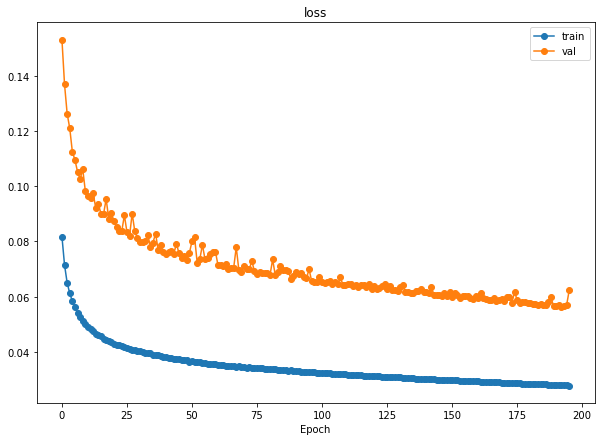

In [35]:
# 초기 loss 5빼고 시각화

plt.title('loss')
plt.plot(train_history[4:], '-o', label='train')
plt.plot(val_history[4:], '-o', label='val')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.gcf().set_size_inches(10, 7)
plt.show()

# ABC

In [36]:
def autocov(series,lag=1):
    n =len(series)
    summ = 0
    for i in range(n-lag):
        summ = summ + series[i]*series[i+lag]
    return summ  

def distance_metric(a,b):
    return torch.sum((a-b)**2)

def MA_sample(theta,n):
    sample = list()
    u = np.random.randn(n+2)
    for i in range(n):
        sample.append(u[i+2] + u[i+1]*theta[0] + u[i]*theta[1])
        
    return sample

In [37]:
def ABC(log_interval, model, device, test_loader,eps=15):
    model.eval()
    test_loss = 0
    res_theta1 = list()
    res_theta2 = list()
    
    y = MA_sample(theta=[0.6,0.2],n=100) # target sample
    y = torch.tensor(y,dtype=torch.float32).to(device)
    
    with torch.no_grad():
        for z, target in test_loader:
            z, target = z.to(device), target.to(device)
            
            z_theta =model(z)
            y_theta = model(y)
            #print(z_theta)
            #print(y_theta)
            
            dist = distance_metric(z_theta,y_theta)
            test_loss += F.mse_loss(z_theta, target, reduction='sum').item() 

            epsilon = eps
            #print(target)
            if dist < epsilon :
                res_theta1.append(target[0,0].item())
                res_theta2.append(target[0,1].item())
                
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))
    
    return res_theta1, res_theta2

In [46]:
theta1, theta2 = ABC(log_interval, model, device, test_loader,eps=0.1)


Test set: Average loss: 0.0628



In [47]:
len(theta1)

9195

In [48]:
len(theta1)/(1e+05)

0.09195

0.731859930737178
0.21939204554972425


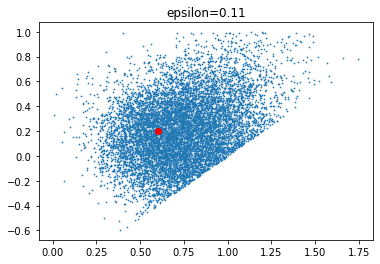

In [49]:
plt.scatter(theta1,theta2,s=0.5)
ylim=[-1,1]
xlim=[-2,2]
plt.title("epsilon=0.11")
plt.scatter(0.6,0.2,color="red")
print(np.mean(theta1))
print(np.mean(theta2))

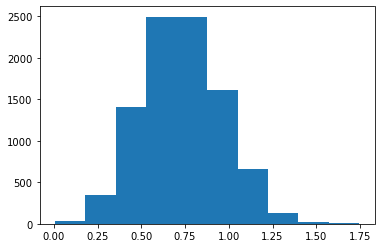

In [51]:
plt.hist(theta1) # 0.6418
plt.show()

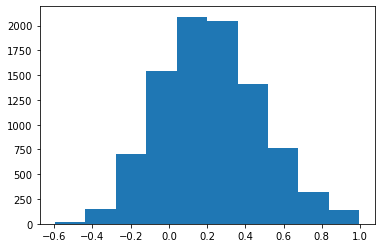

In [52]:
plt.hist(theta2) # 0.2399
plt.show()

In [53]:
# early stopping

In [ ]:
# prior에서 제안한 theta를 이용해서 모델을 만드는 부분에서 input data를 무수히 생성할 수 있다.
# 딥러닝 모델의 입장에서는 굉장히 좋은 조건.
#
# 잘 학습된 모델만 있다면, summary statistic을 만드는게 굉장히 쉽고 정확하다.

# 기존 그림

In [296]:
def theta_sim():
    while(True):
        theta1 = (np.random.random(1))*4 -2
        theta2 = (np.random.random(1))*2 - 1
        cond2 = theta1 + theta2 > -1
        cond3 = theta1 - theta2 < 1
        
        if((cond2 == True)&(cond3 == True)):
            res = np.concatenate((theta1,theta2),axis=0)
            break
    return res


In [301]:
res_theta1 = list()
res_theta2 = list()
idx = 0
y = MA_sample(theta=[0.6,0.2],n=100) # target sample

for i in range(10**6):
    theta = theta_sim()
    z =  MA_sample(theta=theta,n=100)
    
    y_autocov = np.array(autocov(y,lag=1),autocov(y,lag=2))
    z_autocov = np.array(autocov(z,lag=1),autocov(z,lag=2))
        
    dist = np.sum((y_autocov-z_autocov)**2)

    epsilon = 10
    if dist < epsilon :
        idx += 1
        res_theta1.append(theta[0])
        res_theta2.append(theta[1])

In [302]:
len(res_theta1)/(1e+06)

0.015593

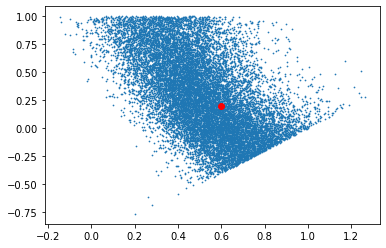

In [303]:
plt.scatter(res_theta1,res_theta2,s=0.5)
ylim=[-1,1]
xlim=[-2,2]
plt.scatter(0.6,0.2,color="red")